In [1]:
from tensorflow import keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [5]:
import seaborn as sns
import pandas as pd
import numpy as np

## Constants and Functions

In [2]:
SEED = 121199
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 50
NUM_CLASSES = 5
BATCH_SIZE = 32

def visualize_result(his, epochs, filename):
    acc = his.history['accuracy']
    val_acc = his.history['val_accuracy']

    loss = his.history['loss']
    val_loss = his.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig(filename)
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=((6, 6)))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('img/' + title + '.png')

## Custom Callbacks

In [3]:
import notifiers
import time
import datetime

class Notifier(tf.keras.callbacks.Callback):
    def __init__(self, model_name):
        super(Notifier, self).__init__()
        self.model_name = model_name
        self.token = 'av4arh4gjmz9x1i2t3oqanyfjxbchc'
        self.user = 'ua2ym7pyg7mjg71gzrdzusrd6hr7bu'
        self.pushover = notifiers.get_notifier('pushover')
        self.message = "{} training completed in {} \nVal Loss: {} | Val Accuracy: {}"
        print('model name: {}'.format(self.model_name))
        
    def on_train_begin(self, logs=None):
        self.start = time.time()

    def on_train_end(self, logs=None):
        self.end = time.time()
        runtime = datetime.timedelta(seconds=self.end - self.start)
        
        if logs:
            msg = self.message.format(self.model_name, runtime,
                                      round(logs['val_loss'], 3),
                                      round(logs['val_accuracy']*100, 3))
        else:
            msg = "{} training completed in {} \nLogs not found".format(self.model_name, runtime)
        print(msg)
        self.pushover.notify(message=msg, token=self.token, user=self.user)
        

## Acquire Data

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import zipfile
# with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('.')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20)

test_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
)

val_ds = test_datagen.flow_from_directory(
    'dataset/val',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
)

test_ds = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False
)

labels = list(test_ds.class_indices.keys())
labels

Found 3237 images belonging to 5 classes.
Found 604 images belonging to 5 classes.
Found 208 images belonging to 5 classes.


['dyskeratotic',
 'koilocytotic',
 'metaplastic',
 'parabasal',
 'superficialIntermediate']

## Model Architecture and HP Tuning

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

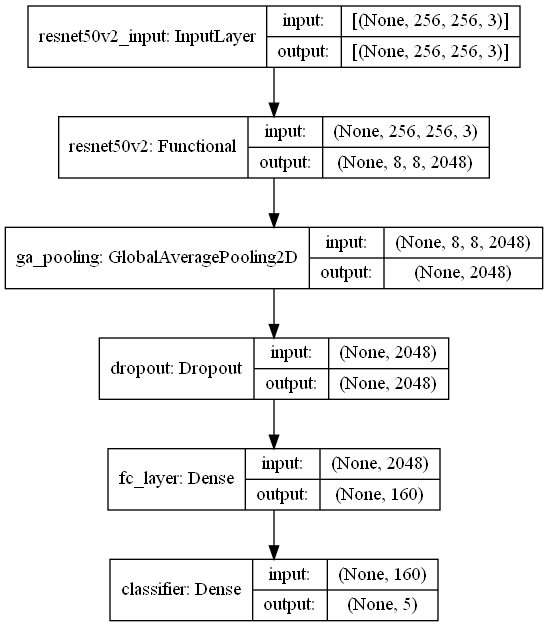

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.applications import ResNet50V2

resnet50_base = ResNet50V2(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

for layer in resnet50_base.layers[:(len(resnet50_base.layers) - 36)]:
    layer.trainable = False
resnet50_base.summary()

resnet50_net = Sequential([
    resnet50_base,
    layers.GlobalAveragePooling2D(name="ga_pooling"),
    layers.Dropout(.3, seed=SEED, name='dropout'),
    layers.Dense(160, activation='tanh', name='fc_layer'),       # fully connected layers
    layers.Dense(NUM_CLASSES, activation='softmax', name='classifier')         # output layer
])

keras.utils.plot_model(resnet50_net, to_file="img/resnet50_arch.png", show_shapes=True)

## HP Tuning

In [17]:
from kerastuner import HyperModel, HyperParameters, RandomSearch
import json

# freeze all but last 2 separable conv block
for layer in resnet50_base.layers[:(len(resnet50_base.layers) - 36)]:
# for layer in resnet50_base.layers:
    layer.trainable = False
    
# resnet50_base.summary()

# -- HYPER MODEL -- #
class HyperCervixNet(HyperModel):
    def __init__(self):
        super().__init__()

    def build(self, hp):
        # hp search space
        fc_units = hp.Int('fc_units', min_value=32, max_value=512,
                          step=32, default=128)
        fc_activation = hp.Choice('fc_activation',
                                  values=['relu', 'tanh', 'sigmoid'],
                                  default='relu')
        dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.4,
                               step=0.1, default=0.3)
        
        # model assembly
        resnet50_net = Sequential([
            resnet50_base,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(dropout_rate, seed=SEED),
            layers.Dense(fc_units, activation=fc_activation),       # fully connected layers
            layers.Dense(NUM_CLASSES, activation='softmax')         # output layer
        ])
        
        # decaying learning rate
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-3,
            decay_steps=10000,
            decay_rate=0.9)
        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
        # compile the model
        resnet50_net.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])
        return resnet50_net
    
hypermodel = HyperCervixNet()

In [22]:
import time
import datetime

# -- TUNER -- #
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 1
SEARCH_EPOCHS = 50

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='random_search',
    project_name='resnet',
)
tuner.search_space_summary()

tuning_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=1e-3, patience=10,
        mode='min', baseline=None, restore_best_weights=True),
    Notifier('ResNet HP Search'),
    tf.keras.callbacks.CSVLogger('logs/resnet_hpsearch.log')
]

start = time.time()
tuner.search(train_ds, epochs=SEARCH_EPOCHS, validation_data=val_ds, callbacks=tuning_callbacks)
end = time.time() - start
print('Resnet hyperparameter search time: {}'.format(datetime.timedelta(seconds=end)))

# Show a summary of the search
tuner.results_summary()
best_hp = tuner.get_best_hyperparameters()[0]
with open('hp/resnet50_best_hp.json', 'w') as f:
    json.dump(best_hp.get_config(), f)
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('models/hp_search/resnet50_best_mt{}_ept{}_se{}.h5'.format(MAX_TRIALS, EXECUTION_PER_TRIAL, SEARCH_EPOCHS))

model name: ResNet HP Search
Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 1.9780 - accuracy: 0.12 - ETA: 24s - loss: 1.4595 - accuracy: 0.484 - ETA: 32s - loss: 1.1370 - accuracy: 0.635 - ETA: 37s - loss: 0.9524 - accuracy: 0.695 - ETA: 37s - loss: 0.8258 - accuracy: 0.737 - ETA: 38s - loss: 0.7655 - accuracy: 0.760 - ETA: 39s - loss: 0.6739 - accuracy: 0.790 - ETA: 40s - loss: 0.6000 - accuracy: 0.812 - ETA: 40s - loss: 0.5409 - accuracy: 0.833 - ETA: 40s - loss: 0.4982 - accuracy: 0.846 - ETA: 40s - loss: 0.4567 - accuracy: 0.860 - ETA: 40s - loss: 0.4423 - accuracy: 0.867 - ETA: 40s - loss: 0.4343 - accuracy: 0.870 - ETA: 40s - loss: 0.4101 - accuracy: 0.877 - ETA: 39s - loss: 0.4085 - accuracy: 0.877 - ETA: 39s - loss: 0.3862 - accuracy: 0.884 - ETA: 38s - loss: 0.3734 - accuracy: 0.887 - ETA: 37s - loss: 0.3640 - accuracy: 0.890 - ETA: 37s - loss: 0.3524 - accuracy: 0.891 - ETA: 37s - loss: 0.3457 - accuracy: 0.892 - ETA: 36s - loss: 0.3428 - accuracy: 0.8

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 1.7901 - accuracy: 0.18 - ETA: 26s - loss: 1.1427 - accuracy: 0.515 - ETA: 35s - loss: 0.8252 - accuracy: 0.666 - ETA: 36s - loss: 0.6268 - accuracy: 0.750 - ETA: 38s - loss: 0.5077 - accuracy: 0.800 - ETA: 39s - loss: 0.4410 - accuracy: 0.822 - ETA: 40s - loss: 0.3797 - accuracy: 0.848 - ETA: 39s - loss: 0.3388 - accuracy: 0.863 - ETA: 40s - loss: 0.3394 - accuracy: 0.871 - ETA: 39s - loss: 0.3064 - accuracy: 0.884 - ETA: 39s - loss: 0.2941 - accuracy: 0.892 - ETA: 39s - loss: 0.2750 - accuracy: 0.898 - ETA: 39s - loss: 0.2540 - accuracy: 0.906 - ETA: 39s - loss: 0.2362 - accuracy: 0.912 - ETA: 39s - loss: 0.2248 - accuracy: 0.916 - ETA: 38s - loss: 0.2107 - accuracy: 0.921 - ETA: 38s - loss: 0.1984 - accuracy: 0.926 - ETA: 38s - loss: 0.2021 - accuracy: 0.925 - ETA: 37s - loss: 0.1947 - accuracy: 0.927 - ETA: 37s - loss: 0.1859 - accuracy: 0.931 - ETA: 36s - loss: 0.1771 - accuracy: 0.934 - ETA: 36s - loss: 0.1715 

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 1.6331 - accuracy: 0.28 - ETA: 23s - loss: 1.3678 - accuracy: 0.421 - ETA: 30s - loss: 1.1327 - accuracy: 0.593 - ETA: 34s - loss: 0.9514 - accuracy: 0.695 - ETA: 35s - loss: 0.8315 - accuracy: 0.756 - ETA: 37s - loss: 0.7280 - accuracy: 0.796 - ETA: 37s - loss: 0.6526 - accuracy: 0.825 - ETA: 38s - loss: 0.6108 - accuracy: 0.835 - ETA: 38s - loss: 0.5521 - accuracy: 0.854 - ETA: 38s - loss: 0.5035 - accuracy: 0.868 - ETA: 38s - loss: 0.4676 - accuracy: 0.877 - ETA: 38s - loss: 0.4344 - accuracy: 0.888 - ETA: 38s - loss: 0.4067 - accuracy: 0.896 - ETA: 38s - loss: 0.3881 - accuracy: 0.899 - ETA: 38s - loss: 0.3652 - accuracy: 0.906 - ETA: 37s - loss: 0.3452 - accuracy: 0.912 - ETA: 37s - loss: 0.3266 - accuracy: 0.917 - ETA: 37s - loss: 0.3093 - accuracy: 0.921 - ETA: 37s - loss: 0.2939 - accuracy: 0.926 - ETA: 36s - loss: 0.2807 - accuracy: 0.929 - ETA: 36s - loss: 0.2678 - accuracy: 0.933 - ETA: 35s - loss: 0.2639 

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 1.8165 - accuracy: 0.15 - ETA: 21s - loss: 1.2125 - accuracy: 0.515 - ETA: 28s - loss: 0.8904 - accuracy: 0.677 - ETA: 32s - loss: 0.7231 - accuracy: 0.750 - ETA: 33s - loss: 0.6012 - accuracy: 0.800 - ETA: 34s - loss: 0.5211 - accuracy: 0.822 - ETA: 36s - loss: 0.4581 - accuracy: 0.843 - ETA: 37s - loss: 0.4121 - accuracy: 0.859 - ETA: 37s - loss: 0.3749 - accuracy: 0.871 - ETA: 37s - loss: 0.3645 - accuracy: 0.878 - ETA: 36s - loss: 0.3325 - accuracy: 0.889 - ETA: 36s - loss: 0.3065 - accuracy: 0.898 - ETA: 36s - loss: 0.2834 - accuracy: 0.906 - ETA: 36s - loss: 0.2650 - accuracy: 0.912 - ETA: 35s - loss: 0.2532 - accuracy: 0.916 - ETA: 35s - loss: 0.2386 - accuracy: 0.921 - ETA: 35s - loss: 0.2251 - accuracy: 0.926 - ETA: 35s - loss: 0.2139 - accuracy: 0.930 - ETA: 35s - loss: 0.2033 - accuracy: 0.934 - ETA: 35s - loss: 0.1937 - accuracy: 0.937 - ETA: 35s - loss: 0.1849 - accuracy: 0.940 - ETA: 34s - loss: 0.1767 

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 2.0181 - accuracy: 0.28 - ETA: 25s - loss: 1.7201 - accuracy: 0.265 - ETA: 30s - loss: 1.3536 - accuracy: 0.479 - ETA: 34s - loss: 1.1360 - accuracy: 0.601 - ETA: 35s - loss: 0.9796 - accuracy: 0.675 - ETA: 37s - loss: 0.8642 - accuracy: 0.724 - ETA: 38s - loss: 0.7606 - accuracy: 0.763 - ETA: 38s - loss: 0.6851 - accuracy: 0.793 - ETA: 37s - loss: 0.6221 - accuracy: 0.816 - ETA: 37s - loss: 0.5651 - accuracy: 0.834 - ETA: 37s - loss: 0.5239 - accuracy: 0.849 - ETA: 36s - loss: 0.4889 - accuracy: 0.862 - ETA: 36s - loss: 0.4534 - accuracy: 0.872 - ETA: 36s - loss: 0.4345 - accuracy: 0.877 - ETA: 36s - loss: 0.4076 - accuracy: 0.885 - ETA: 36s - loss: 0.3873 - accuracy: 0.892 - ETA: 35s - loss: 0.3674 - accuracy: 0.898 - ETA: 35s - loss: 0.3485 - accuracy: 0.904 - ETA: 35s - loss: 0.3310 - accuracy: 0.909 - ETA: 35s - loss: 0.3156 - accuracy: 0.914 - ETA: 34s - loss: 0.3016 - accuracy: 0.918 - ETA: 34s - loss: 0.2922 

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 1.9663 - accuracy: 0.21 - ETA: 20s - loss: 1.0720 - accuracy: 0.593 - ETA: 27s - loss: 0.7388 - accuracy: 0.718 - ETA: 30s - loss: 0.5581 - accuracy: 0.789 - ETA: 34s - loss: 0.4528 - accuracy: 0.825 - ETA: 36s - loss: 0.3777 - accuracy: 0.854 - ETA: 36s - loss: 0.3552 - accuracy: 0.866 - ETA: 36s - loss: 0.3138 - accuracy: 0.882 - ETA: 36s - loss: 0.2956 - accuracy: 0.892 - ETA: 36s - loss: 0.2661 - accuracy: 0.903 - ETA: 37s - loss: 0.2419 - accuracy: 0.911 - ETA: 36s - loss: 0.2271 - accuracy: 0.916 - ETA: 36s - loss: 0.2173 - accuracy: 0.920 - ETA: 36s - loss: 0.2018 - accuracy: 0.926 - ETA: 35s - loss: 0.1889 - accuracy: 0.931 - ETA: 36s - loss: 0.1852 - accuracy: 0.933 - ETA: 35s - loss: 0.1745 - accuracy: 0.937 - ETA: 35s - loss: 0.1657 - accuracy: 0.941 - ETA: 35s - loss: 0.1583 - accuracy: 0.942 - ETA: 34s - loss: 0.1510 - accuracy: 0.945 - ETA: 34s - loss: 0.1438 - accuracy: 0.947 - ETA: 34s - loss: 0.1373 

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 1.7224 - accuracy: 0.09 - ETA: 21s - loss: 1.4812 - accuracy: 0.328 - ETA: 27s - loss: 1.2788 - accuracy: 0.541 - ETA: 31s - loss: 1.1277 - accuracy: 0.648 - ETA: 32s - loss: 1.0177 - accuracy: 0.712 - ETA: 34s - loss: 0.9286 - accuracy: 0.760 - ETA: 36s - loss: 0.8413 - accuracy: 0.794 - ETA: 37s - loss: 0.7719 - accuracy: 0.820 - ETA: 37s - loss: 0.7080 - accuracy: 0.840 - ETA: 38s - loss: 0.6537 - accuracy: 0.856 - ETA: 37s - loss: 0.6089 - accuracy: 0.869 - ETA: 37s - loss: 0.5710 - accuracy: 0.880 - ETA: 37s - loss: 0.5421 - accuracy: 0.889 - ETA: 37s - loss: 0.5143 - accuracy: 0.897 - ETA: 36s - loss: 0.4883 - accuracy: 0.904 - ETA: 36s - loss: 0.4666 - accuracy: 0.910 - ETA: 36s - loss: 0.4441 - accuracy: 0.915 - ETA: 35s - loss: 0.4226 - accuracy: 0.920 - ETA: 35s - loss: 0.4034 - accuracy: 0.924 - ETA: 35s - loss: 0.3854 - accuracy: 0.928 - ETA: 34s - loss: 0.3724 - accuracy: 0.931 - ETA: 34s - loss: 0.3581 

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 1.6262 - accuracy: 0.28 - ETA: 21s - loss: 1.1131 - accuracy: 0.562 - ETA: 28s - loss: 0.8296 - accuracy: 0.708 - ETA: 31s - loss: 0.6414 - accuracy: 0.781 - ETA: 33s - loss: 0.5430 - accuracy: 0.825 - ETA: 34s - loss: 0.4604 - accuracy: 0.854 - ETA: 35s - loss: 0.3970 - accuracy: 0.875 - ETA: 35s - loss: 0.3505 - accuracy: 0.890 - ETA: 35s - loss: 0.3125 - accuracy: 0.902 - ETA: 36s - loss: 0.2822 - accuracy: 0.912 - ETA: 36s - loss: 0.2574 - accuracy: 0.920 - ETA: 35s - loss: 0.2376 - accuracy: 0.927 - ETA: 35s - loss: 0.2195 - accuracy: 0.932 - ETA: 35s - loss: 0.2041 - accuracy: 0.937 - ETA: 35s - loss: 0.1924 - accuracy: 0.941 - ETA: 35s - loss: 0.1810 - accuracy: 0.945 - ETA: 35s - loss: 0.1704 - accuracy: 0.948 - ETA: 35s - loss: 0.1620 - accuracy: 0.951 - ETA: 35s - loss: 0.1535 - accuracy: 0.953 - ETA: 34s - loss: 0.1460 - accuracy: 0.956 - ETA: 34s - loss: 0.1392 - accuracy: 0.958 - ETA: 34s - loss: 0.1333 

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 1.7741 - accuracy: 0.18 - ETA: 6s - loss: 1.7210 - accuracy: 0.21 - ETA: 27s - loss: 1.2225 - accuracy: 0.521 - ETA: 31s - loss: 1.0217 - accuracy: 0.613 - ETA: 34s - loss: 0.8271 - accuracy: 0.706 - ETA: 35s - loss: 0.7102 - accuracy: 0.763 - ETA: 35s - loss: 0.6125 - accuracy: 0.802 - ETA: 36s - loss: 0.5486 - accuracy: 0.829 - ETA: 36s - loss: 0.4884 - accuracy: 0.850 - ETA: 36s - loss: 0.4434 - accuracy: 0.863 - ETA: 36s - loss: 0.4018 - accuracy: 0.876 - ETA: 36s - loss: 0.3731 - accuracy: 0.885 - ETA: 36s - loss: 0.3527 - accuracy: 0.892 - ETA: 36s - loss: 0.3268 - accuracy: 0.900 - ETA: 36s - loss: 0.3082 - accuracy: 0.905 - ETA: 36s - loss: 0.2904 - accuracy: 0.911 - ETA: 36s - loss: 0.2728 - accuracy: 0.916 - ETA: 35s - loss: 0.2574 - accuracy: 0.921 - ETA: 35s - loss: 0.2448 - accuracy: 0.926 - ETA: 35s - loss: 0.2328 - accuracy: 0.929 - ETA: 35s - loss: 0.2224 - accuracy: 0.933 - ETA: 34s - loss: 0.2124 - 

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 1.3636 - accuracy: 0.31 - ETA: 21s - loss: 0.7895 - accuracy: 0.625 - ETA: 27s - loss: 0.5310 - accuracy: 0.750 - ETA: 32s - loss: 0.4011 - accuracy: 0.812 - ETA: 35s - loss: 0.3236 - accuracy: 0.850 - ETA: 36s - loss: 0.2704 - accuracy: 0.875 - ETA: 36s - loss: 0.2318 - accuracy: 0.892 - ETA: 36s - loss: 0.2130 - accuracy: 0.902 - ETA: 37s - loss: 0.1935 - accuracy: 0.909 - ETA: 37s - loss: 0.1746 - accuracy: 0.918 - ETA: 36s - loss: 0.1588 - accuracy: 0.926 - ETA: 37s - loss: 0.1457 - accuracy: 0.932 - ETA: 37s - loss: 0.1345 - accuracy: 0.937 - ETA: 36s - loss: 0.1250 - accuracy: 0.942 - ETA: 36s - loss: 0.1208 - accuracy: 0.943 - ETA: 36s - loss: 0.1141 - accuracy: 0.947 - ETA: 35s - loss: 0.1073 - accuracy: 0.950 - ETA: 35s - loss: 0.1014 - accuracy: 0.953 - ETA: 35s - loss: 0.0964 - accuracy: 0.955 - ETA: 35s - loss: 0.0915 - accuracy: 0.957 - ETA: 34s - loss: 0.0915 - accuracy: 0.958 - ETA: 34s - loss: 0.0876 

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 2.0411 - accuracy: 0.21 - ETA: 22s - loss: 1.1430 - accuracy: 0.609 - ETA: 28s - loss: 0.7833 - accuracy: 0.739 - ETA: 31s - loss: 0.5894 - accuracy: 0.804 - ETA: 33s - loss: 0.4762 - accuracy: 0.843 - ETA: 35s - loss: 0.4002 - accuracy: 0.869 - ETA: 36s - loss: 0.3443 - accuracy: 0.888 - ETA: 36s - loss: 0.3014 - accuracy: 0.902 - ETA: 36s - loss: 0.2686 - accuracy: 0.913 - ETA: 36s - loss: 0.2422 - accuracy: 0.921 - ETA: 36s - loss: 0.2203 - accuracy: 0.929 - ETA: 36s - loss: 0.2019 - accuracy: 0.934 - ETA: 36s - loss: 0.1864 - accuracy: 0.939 - ETA: 35s - loss: 0.1736 - accuracy: 0.944 - ETA: 35s - loss: 0.1620 - accuracy: 0.947 - ETA: 35s - loss: 0.1519 - accuracy: 0.951 - ETA: 35s - loss: 0.1430 - accuracy: 0.954 - ETA: 35s - loss: 0.1352 - accuracy: 0.956 - ETA: 35s - loss: 0.1281 - accuracy: 0.958 - ETA: 35s - loss: 0.1221 - accuracy: 0.960 - ETA: 34s - loss: 0.1163 - accuracy: 0.962 - ETA: 34s - loss: 0.1111 

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 2.0118 - accuracy: 0.12 - ETA: 23s - loss: 1.2427 - accuracy: 0.531 - ETA: 30s - loss: 0.9108 - accuracy: 0.677 - ETA: 32s - loss: 0.7215 - accuracy: 0.757 - ETA: 35s - loss: 0.5836 - accuracy: 0.806 - ETA: 35s - loss: 0.4878 - accuracy: 0.838 - ETA: 35s - loss: 0.4216 - accuracy: 0.861 - ETA: 36s - loss: 0.3703 - accuracy: 0.878 - ETA: 36s - loss: 0.3298 - accuracy: 0.892 - ETA: 36s - loss: 0.2992 - accuracy: 0.903 - ETA: 36s - loss: 0.2723 - accuracy: 0.911 - ETA: 36s - loss: 0.2499 - accuracy: 0.919 - ETA: 36s - loss: 0.2308 - accuracy: 0.925 - ETA: 36s - loss: 0.2158 - accuracy: 0.930 - ETA: 36s - loss: 0.2016 - accuracy: 0.935 - ETA: 35s - loss: 0.1890 - accuracy: 0.939 - ETA: 36s - loss: 0.1780 - accuracy: 0.943 - ETA: 35s - loss: 0.1694 - accuracy: 0.946 - ETA: 35s - loss: 0.1608 - accuracy: 0.949 - ETA: 35s - loss: 0.1528 - accuracy: 0.951 - ETA: 34s - loss: 0.1455 - accuracy: 0.953 - ETA: 34s - loss: 0.1390 

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 1.6285 - accuracy: 0.21 - ETA: 21s - loss: 1.2120 - accuracy: 0.593 - ETA: 28s - loss: 0.9511 - accuracy: 0.729 - ETA: 31s - loss: 0.7892 - accuracy: 0.796 - ETA: 34s - loss: 0.6624 - accuracy: 0.837 - ETA: 34s - loss: 0.5696 - accuracy: 0.864 - ETA: 35s - loss: 0.5008 - accuracy: 0.879 - ETA: 36s - loss: 0.4471 - accuracy: 0.894 - ETA: 36s - loss: 0.4073 - accuracy: 0.906 - ETA: 37s - loss: 0.3682 - accuracy: 0.915 - ETA: 37s - loss: 0.3357 - accuracy: 0.923 - ETA: 37s - loss: 0.3087 - accuracy: 0.929 - ETA: 37s - loss: 0.2869 - accuracy: 0.935 - ETA: 37s - loss: 0.2672 - accuracy: 0.939 - ETA: 37s - loss: 0.2499 - accuracy: 0.943 - ETA: 37s - loss: 0.2347 - accuracy: 0.947 - ETA: 37s - loss: 0.2211 - accuracy: 0.950 - ETA: 36s - loss: 0.2090 - accuracy: 0.953 - ETA: 36s - loss: 0.1987 - accuracy: 0.955 - ETA: 36s - loss: 0.1890 - accuracy: 0.957 - ETA: 35s - loss: 0.1808 - accuracy: 0.959 - ETA: 35s - loss: 0.1741 

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 1.8909 - accuracy: 0.12 - ETA: 22s - loss: 1.1213 - accuracy: 0.500 - ETA: 31s - loss: 0.7934 - accuracy: 0.666 - ETA: 34s - loss: 0.6034 - accuracy: 0.750 - ETA: 35s - loss: 0.4923 - accuracy: 0.800 - ETA: 37s - loss: 0.4127 - accuracy: 0.833 - ETA: 37s - loss: 0.3544 - accuracy: 0.857 - ETA: 37s - loss: 0.3110 - accuracy: 0.875 - ETA: 37s - loss: 0.2778 - accuracy: 0.888 - ETA: 37s - loss: 0.2868 - accuracy: 0.890 - ETA: 37s - loss: 0.2621 - accuracy: 0.900 - ETA: 37s - loss: 0.2403 - accuracy: 0.908 - ETA: 37s - loss: 0.2218 - accuracy: 0.915 - ETA: 36s - loss: 0.2060 - accuracy: 0.921 - ETA: 36s - loss: 0.1923 - accuracy: 0.927 - ETA: 36s - loss: 0.1803 - accuracy: 0.931 - ETA: 36s - loss: 0.1697 - accuracy: 0.935 - ETA: 35s - loss: 0.1603 - accuracy: 0.939 - ETA: 35s - loss: 0.1519 - accuracy: 0.942 - ETA: 35s - loss: 0.1444 - accuracy: 0.945 - ETA: 35s - loss: 0.1375 - accuracy: 0.947 - ETA: 34s - loss: 0.1313 

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 1.7953 - accuracy: 0.21 - ETA: 21s - loss: 1.2629 - accuracy: 0.593 - ETA: 27s - loss: 0.9421 - accuracy: 0.729 - ETA: 33s - loss: 0.7869 - accuracy: 0.781 - ETA: 34s - loss: 0.6835 - accuracy: 0.825 - ETA: 35s - loss: 0.5859 - accuracy: 0.854 - ETA: 36s - loss: 0.5097 - accuracy: 0.875 - ETA: 36s - loss: 0.4535 - accuracy: 0.890 - ETA: 37s - loss: 0.4067 - accuracy: 0.902 - ETA: 37s - loss: 0.3691 - accuracy: 0.912 - ETA: 37s - loss: 0.3370 - accuracy: 0.920 - ETA: 37s - loss: 0.3169 - accuracy: 0.924 - ETA: 37s - loss: 0.2941 - accuracy: 0.930 - ETA: 37s - loss: 0.2740 - accuracy: 0.935 - ETA: 37s - loss: 0.2564 - accuracy: 0.939 - ETA: 37s - loss: 0.2407 - accuracy: 0.943 - ETA: 37s - loss: 0.2288 - accuracy: 0.944 - ETA: 36s - loss: 0.2167 - accuracy: 0.947 - ETA: 36s - loss: 0.2054 - accuracy: 0.950 - ETA: 35s - loss: 0.1971 - accuracy: 0.953 - ETA: 35s - loss: 0.1882 - accuracy: 0.955 - ETA: 34s - loss: 0.1803 

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 2.0299 - accuracy: 0.21 - ETA: 21s - loss: 1.2875 - accuracy: 0.531 - ETA: 28s - loss: 0.8979 - accuracy: 0.687 - ETA: 32s - loss: 0.6887 - accuracy: 0.765 - ETA: 34s - loss: 0.5544 - accuracy: 0.812 - ETA: 35s - loss: 0.4641 - accuracy: 0.843 - ETA: 36s - loss: 0.4060 - accuracy: 0.866 - ETA: 37s - loss: 0.3568 - accuracy: 0.882 - ETA: 37s - loss: 0.3176 - accuracy: 0.895 - ETA: 37s - loss: 0.2887 - accuracy: 0.906 - ETA: 37s - loss: 0.2629 - accuracy: 0.914 - ETA: 37s - loss: 0.2429 - accuracy: 0.921 - ETA: 37s - loss: 0.2243 - accuracy: 0.927 - ETA: 36s - loss: 0.2083 - accuracy: 0.933 - ETA: 36s - loss: 0.1945 - accuracy: 0.937 - ETA: 36s - loss: 0.1824 - accuracy: 0.941 - ETA: 36s - loss: 0.1717 - accuracy: 0.944 - ETA: 35s - loss: 0.1622 - accuracy: 0.947 - ETA: 35s - loss: 0.1540 - accuracy: 0.950 - ETA: 35s - loss: 0.1468 - accuracy: 0.953 - ETA: 34s - loss: 0.1399 - accuracy: 0.955 - ETA: 34s - loss: 0.1335 

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 2.0737 - accuracy: 0.18 - ETA: 20s - loss: 1.3485 - accuracy: 0.546 - ETA: 28s - loss: 1.0090 - accuracy: 0.687 - ETA: 32s - loss: 0.7906 - accuracy: 0.765 - ETA: 35s - loss: 0.6578 - accuracy: 0.812 - ETA: 36s - loss: 0.5586 - accuracy: 0.843 - ETA: 36s - loss: 0.4826 - accuracy: 0.866 - ETA: 36s - loss: 0.4246 - accuracy: 0.882 - ETA: 36s - loss: 0.3800 - accuracy: 0.895 - ETA: 36s - loss: 0.3423 - accuracy: 0.906 - ETA: 36s - loss: 0.3118 - accuracy: 0.914 - ETA: 36s - loss: 0.2871 - accuracy: 0.921 - ETA: 36s - loss: 0.2672 - accuracy: 0.927 - ETA: 36s - loss: 0.2625 - accuracy: 0.928 - ETA: 36s - loss: 0.2470 - accuracy: 0.933 - ETA: 36s - loss: 0.2324 - accuracy: 0.937 - ETA: 36s - loss: 0.2224 - accuracy: 0.939 - ETA: 35s - loss: 0.2109 - accuracy: 0.942 - ETA: 35s - loss: 0.2001 - accuracy: 0.945 - ETA: 35s - loss: 0.1901 - accuracy: 0.948 - ETA: 35s - loss: 0.1811 - accuracy: 0.950 - ETA: 34s - loss: 0.1735 

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 1.7981 - accuracy: 0.09 - ETA: 21s - loss: 1.3700 - accuracy: 0.390 - ETA: 29s - loss: 1.0853 - accuracy: 0.593 - ETA: 32s - loss: 0.8769 - accuracy: 0.695 - ETA: 34s - loss: 0.7384 - accuracy: 0.756 - ETA: 35s - loss: 0.6311 - accuracy: 0.796 - ETA: 36s - loss: 0.5486 - accuracy: 0.825 - ETA: 37s - loss: 0.4905 - accuracy: 0.847 - ETA: 37s - loss: 0.4382 - accuracy: 0.864 - ETA: 37s - loss: 0.3995 - accuracy: 0.878 - ETA: 37s - loss: 0.3679 - accuracy: 0.886 - ETA: 37s - loss: 0.3378 - accuracy: 0.895 - ETA: 34s - loss: 0.3336 - accuracy: 0.897 - ETA: 36s - loss: 0.3088 - accuracy: 0.905 - ETA: 36s - loss: 0.2886 - accuracy: 0.911 - ETA: 35s - loss: 0.2700 - accuracy: 0.917 - ETA: 35s - loss: 0.2537 - accuracy: 0.922 - ETA: 35s - loss: 0.2416 - accuracy: 0.925 - ETA: 35s - loss: 0.2283 - accuracy: 0.929 - ETA: 35s - loss: 0.2164 - accuracy: 0.933 - ETA: 34s - loss: 0.2060 - accuracy: 0.936 - ETA: 34s - loss: 0.1967 

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 1.8822 - accuracy: 0.15 - ETA: 24s - loss: 1.0884 - accuracy: 0.562 - ETA: 30s - loss: 0.7578 - accuracy: 0.708 - ETA: 34s - loss: 0.5732 - accuracy: 0.781 - ETA: 35s - loss: 0.4595 - accuracy: 0.825 - ETA: 35s - loss: 0.3833 - accuracy: 0.854 - ETA: 36s - loss: 0.3293 - accuracy: 0.875 - ETA: 36s - loss: 0.2887 - accuracy: 0.890 - ETA: 36s - loss: 0.2567 - accuracy: 0.902 - ETA: 37s - loss: 0.2310 - accuracy: 0.912 - ETA: 37s - loss: 0.2100 - accuracy: 0.920 - ETA: 37s - loss: 0.1986 - accuracy: 0.924 - ETA: 37s - loss: 0.1833 - accuracy: 0.930 - ETA: 37s - loss: 0.1702 - accuracy: 0.935 - ETA: 37s - loss: 0.1589 - accuracy: 0.939 - ETA: 37s - loss: 0.1490 - accuracy: 0.943 - ETA: 37s - loss: 0.1402 - accuracy: 0.946 - ETA: 36s - loss: 0.1325 - accuracy: 0.949 - ETA: 36s - loss: 0.1255 - accuracy: 0.952 - ETA: 36s - loss: 0.1192 - accuracy: 0.954 - ETA: 35s - loss: 0.1136 - accuracy: 0.956 - ETA: 35s - loss: 0.1084 

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 1.9709 - accuracy: 0.12 - ETA: 22s - loss: 1.7209 - accuracy: 0.328 - ETA: 30s - loss: 1.5562 - accuracy: 0.416 - ETA: 35s - loss: 1.4009 - accuracy: 0.515 - ETA: 37s - loss: 1.3165 - accuracy: 0.568 - ETA: 37s - loss: 1.2164 - accuracy: 0.630 - ETA: 38s - loss: 1.1590 - accuracy: 0.665 - ETA: 38s - loss: 1.1029 - accuracy: 0.695 - ETA: 38s - loss: 1.0366 - accuracy: 0.729 - ETA: 37s - loss: 0.9874 - accuracy: 0.756 - ETA: 37s - loss: 0.9340 - accuracy: 0.778 - ETA: 37s - loss: 0.8916 - accuracy: 0.796 - ETA: 37s - loss: 0.8544 - accuracy: 0.812 - ETA: 37s - loss: 0.8279 - accuracy: 0.825 - ETA: 37s - loss: 0.7957 - accuracy: 0.837 - ETA: 36s - loss: 0.7694 - accuracy: 0.847 - ETA: 36s - loss: 0.7429 - accuracy: 0.856 - ETA: 36s - loss: 0.7209 - accuracy: 0.864 - ETA: 35s - loss: 0.7010 - accuracy: 0.871 - ETA: 35s - loss: 0.6795 - accuracy: 0.878 - ETA: 35s - loss: 0.6630 - accuracy: 0.882 - ETA: 34s - loss: 0.6475 

INFO:tensorflow:Oracle triggered exit
Resnet hyperparameter search time: 5:37:26.563292


## Refitting the Model

model name: ResNet refit
Epoch 1/200
102/102 - 52s - loss: 0.0097 - accuracy: 0.9972 - val_loss: 0.2478 - val_accuracy: 0.9536
Epoch 2/200
102/102 - 53s - loss: 0.0199 - accuracy: 0.9944 - val_loss: 0.2892 - val_accuracy: 0.9321
Epoch 3/200
102/102 - 52s - loss: 0.0208 - accuracy: 0.9929 - val_loss: 0.1886 - val_accuracy: 0.9536
Epoch 4/200
102/102 - 51s - loss: 0.0054 - accuracy: 0.9981 - val_loss: 0.1696 - val_accuracy: 0.9586
Epoch 5/200
102/102 - 51s - loss: 0.0070 - accuracy: 0.9978 - val_loss: 0.1963 - val_accuracy: 0.9536
Epoch 6/200
102/102 - 52s - loss: 0.0068 - accuracy: 0.9972 - val_loss: 0.2147 - val_accuracy: 0.9470
Epoch 7/200
102/102 - 52s - loss: 0.0120 - accuracy: 0.9957 - val_loss: 0.2339 - val_accuracy: 0.9520
Epoch 8/200
102/102 - 52s - loss: 0.0095 - accuracy: 0.9969 - val_loss: 0.2440 - val_accuracy: 0.9454
Epoch 9/200
102/102 - 51s - loss: 0.0244 - accuracy: 0.9929 - val_loss: 0.2157 - val_accuracy: 0.9421
Epoch 10/200
102/102 - 50s - loss: 0.0091 - accuracy: 0.9

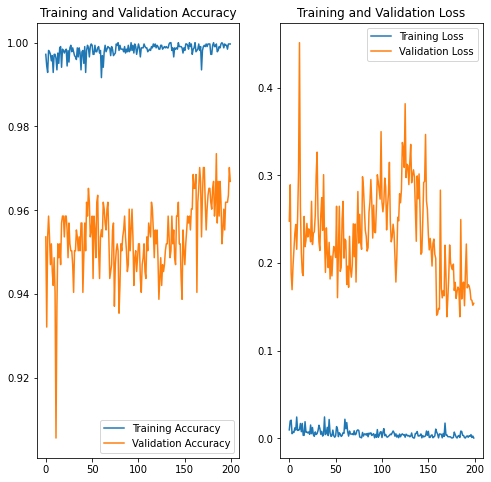

In [23]:
fit_callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss', min_delta=1e-4, patience=10,
#         mode='min', baseline=None, restore_best_weights=True),
    Notifier('ResNet refit'),
    tf.keras.callbacks.CSVLogger('logs/resnet_refit.log')
]

start = time.time()
history = best_model.fit(train_ds, epochs=200, validation_data=val_ds, verbose=2, callbacks=fit_callbacks)
end = time.time() - start
print('Resnet refit time: {}'.format(datetime.timedelta(seconds=end)))
n_epochs_best = len(history.history['val_loss'])

filename = 'resnet_best_refit_e{}'.format(n_epochs_best)
best_model.save('models/{}.h5'.format(filename))
visualize_result(history, n_epochs_best, 'img/' + filename + '.png')

## Evaluating the Model

Confusion matrix, without normalization
[[41  0  1  0  0]
 [ 0 42  0  0  0]
 [ 0  1 40  0  0]
 [ 0  0  0 40  0]
 [ 1  0  0  0 42]]


0.9855769230769231

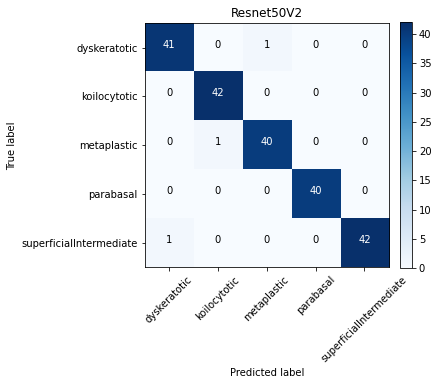

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
import numpy as np

y_true = test_ds.classes

model = keras.models.load_model('models/resnet_best_refit_e200.h5')
y_pred = model.predict(test_ds)
rounded_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true=y_true, y_pred=rounded_pred)
plot_confusion_matrix(cm, labels, title="Resnet50V2")

accuracy_score(y_true, rounded_pred)

In [6]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

print(cm)
print(labels)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
# F1 score
F1 = 2*TP / (2*TP+FP+FN)

print("Sensitivity:", TPR)
print("Specificity:", TNR)
print("F1-score:", F1)

[[41  0  1  0  0]
 [ 0 42  0  0  0]
 [ 0  1 40  0  0]
 [ 0  0  0 40  0]
 [ 1  0  0  0 42]]
['dyskeratotic', 'koilocytotic', 'metaplastic', 'parabasal', 'superficialIntermediate']
Sensitivity: [0.97619048 1.         0.97560976 1.         0.97674419]
Specificity: [0.9939759  0.9939759  0.99401198 1.         1.        ]
F1-score: [0.97619048 0.98823529 0.97560976 1.         0.98823529]


## Extracting Misclassified Images

In [6]:
model = keras.models.load_model('models/resnet_best_refit_e200.h5')
y_pred = model.predict(test_ds)
rounded_pred = np.argmax(y_pred, axis=1)
print(rounded_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


[ 19 108 165]
dataset\test\dyskeratotic\076_02.bmp
True: dyskeratotic, predicted: metaplastic


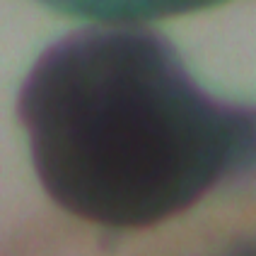

dataset\test\metaplastic\164_04.bmp
True: metaplastic, predicted: koilocytotic


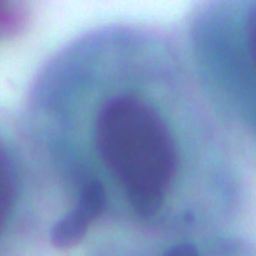

dataset\test\superficialIntermediate\005_04.bmp
True: superficialIntermediate, predicted: dyskeratotic


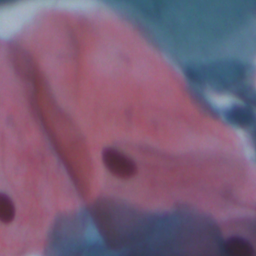

In [8]:
from PIL import Image
from shutil import copyfile

y_true = test_ds.classes
incorrects = np.nonzero(rounded_pred.reshape((-1,)) != y_true)
print(incorrects[0])

n_test = len(test_ds)
filenames = []

for root, dirs, files in os.walk("dataset\\test"):
    for file in files:
        filenames.append(os.path.join(root, file))

for i in incorrects[0]:
    path_to_file = filenames[i]

    img = Image.open(path_to_file)
    true_label = labels[y_true[i]]
    pred_label = labels[rounded_pred[i]]
    img = img.resize((256, 256))
    img.save("img\\misclassified\\resnet\\{}_{}.png".format(true_label[:3], pred_label[:3]))
    print(path_to_file)
    print("True: {}, predicted: {}".format(true_label, pred_label))
    display(img)